In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from Bio import SeqIO
import SearchTools

%matplotlib inline
sbn.set(font_scale=1.5)
sbn.set_style('white')


In [2]:
from itertools import compress
from collections import deque

def get_start_stop(seqR, hxb2_pos):
    
    it = zip(str(seqR.seq), hxb2_pos)
    poses = compress(it, (x[0] != '-' for x in it))
    start = poses.next()[1]
    stop = deque(poses, maxlen=1)[0][1]
    return start, stop
    

In [3]:
import tarfile
from collections import Counter
from copy import deepcopy

seq_locs = []

with tarfile.open('data/LANLdata.tar.gz', mode='r:gz') as tr:
    for f in tr:
        
        parts = f.name.split('/')[-1].split('.')[0].split('-')
        offset = int(parts[1])
        print f.name
        
        seqs = list(SeqIO.parse(tr.extractfile(f), 'fasta'))
        hxb2 = seqs[-1]

        hxb2_pos = []
        pos = offset-1
        for hx_l in str(hxb2.seq):
            pos += hx_l != '-'
            hxb2_pos.append(pos)

        for seqR in seqs[:-1]:
            if len(seqR.seq.ungap('-')) > 50:
                start, stop = get_start_stop(seqR, hxb2_pos)
                seq_locs.append({'sStart': start,
                                 'sStop': stop,
                                 'SeqR': deepcopy(seqR),
                                 'Name': seqR.id})

            
seq_df = pd.DataFrame(seq_locs)
print 'Total sequences imported', len(seq_locs)
seq_df.head()



hiv-2500-3000.fixed.fst
hiv-1100-1950.fixed.fst
hiv-8300-8900.fixed.fst
hiv-7100-7500.fixed.fst
hiv-5200-5600.fixed.fst
hiv-1-700.fixed.fst
hiv-8500-8800.fixed.fst
hiv-6200-6900.fixed.fst
hiv-700-1150.fixed.fst
hiv-2000-2500.fixed.fst
hiv-5700-6100.fixed.fst
hiv-9086-9717.fixed.fst
hiv-4100-4900.fixed.fst
hiv-3000-3500.fixed.fst
hiv-7500-7900.fixed.fst
hiv-3200-3500.fixed.fst
Total sequences imported 390290


,Name,SeqR,sStart,sStop
0,B.US.1997.ARES2.AB078005,"(A, C, A, T, A, A, T, T, G, -, -, -, -, -, G, ...",2500,3000
1,B.US.1985.Ba_L.AB221005,"(A, C, A, T, A, A, T, T, G, -, -, -, -, -, G, ...",2500,3000
2,B.US.1985.Ba_L.AB253432,"(A, C, A, T, A, A, T, T, G, -, -, -, -, -, G, ...",2500,3000
3,B.US.1991.US2.AB485638,"(A, C, A, T, A, A, T, T, G, -, -, -, -, -, G, ...",2500,3000
4,B.US.1991.US2.AB485639,"(A, C, A, T, A, A, T, T, G, -, -, -, -, -, G, ...",2500,3000


In [4]:
ex_df = pd.read_excel('data/gRNAList.xlsx').sort_values(by = 'Start')
ex_df.head()

,Citation,Name,Start,Stop,gRNA,Region
142,26581162,sg45F,27,47,CGACAAGAGATCCTTGATCTG.NGG,LTR
0,26607397,LTR-1,28,47,GACAAGATATCCTTGATCTG.NGG,LTR
19,27341108,gRNA 1,28,47,GACAAGATATCCTTGATCTG.NGG,LTR
7,26775808,sgRNA 1,28,47,GACAAGATATCCTTGATCTG.NGG,LTR
72,25808449,T1,28,47,GACAAGATATCCTTGATCTG.NGG,LTR


In [16]:
from Bio.Seq import reverse_complement


In [8]:
def parse_grna(gRNA):
    
    parts = gRNA.split('.')
    if len(parts[1]) == 3:
        direc = 'Forward'
        proto = parts[0][-20:]
    else:
        direc = 'Reverse'
        proto = parts[1][:20]
        
    if len(proto) < 20:
        proto = 'N'*(20-len(proto)) + proto
        
    return direc, proto


def check_whole_seq(seq, gRNA):
    
    
    
    direc, query = parse_grna(gRNA)
    
    if direc == 'Reverse':
        nseq = seq.ungap('-')[::-1]
        query = query[::-1]
        #query = query.reverse_complement()
        #query = reverse_complement(query.encode('ascii'))
    else:
        nseq = seq.ungap('-')
        #query = proto
    
    scores = []

    for start in range(len(nseq)-20):
        scores.append(SearchTools.gRNA_score_hit(query, nseq[start:start+20]))

    scores = pd.Series(scores)
    bscore, bloc = scores.max(), scores.idxmax()
    
    oseq = str(nseq[bloc:bloc+23])
    has_pam = oseq.endswith('GG')
    if direc == 'Reverse':
        oseq = oseq.encode('ascii')[::-1]
        has_pam = oseq.startswith('CC')
    
    return oseq, bscore, direc, has_pam
    

In [9]:
num = 0
scores = []
for _, row in ex_df.iterrows():
    
    mask = (seq_df['sStart'] < (row['Start']-20)) & (seq_df['sStop'] > (row['Stop']+20))
    for _, seq_row in seq_df.ix[mask].iterrows():
        num += 1
        if num % 5000 == 0:
            print num, row['gRNA name']
        
        try:
            hit, score, direc, has_pam = check_whole_seq(seq_row['SeqR'].seq, row['gRNA sequence'])
        except IndexError:
            continue
    
        scores.append({'Hit': str(hit),
                       'Score': score,
                       'gRNA': row['gRNA sequence'],
                       'Citation': row['citation'],
                       'Type': row['Type'],
                       'Direc': direc,
                       'SeqID': seq_row['Name'],
                       'gStart': row['Start'],
                       'gStop': row['Stop'],
                       'HasPam': has_pam,
                       'Name': row['gRNA name'],
                       'Region': row['REGION'],
                       'gRNAType': row['Type']})

score_df = pd.DataFrame(scores)
score_df.head()   

5000 LTR-H
10000 gLTR1
15000 gRNA A
20000 LTR-I
25000 sg129R
30000 sg221F
35000 LTR-T
40000 gRNA 3
45000 LTR-K
50000 gLTR5
55000 sgRNA 4
60000 LTR-M
65000  LTR-B sgRNA
70000 sgRNA 5
75000 LTR-O
80000 sg362F
85000 sg349R
90000 sg371F
95000 LTR-Q
100000 LTR-5
105000 LTR-D
110000 LTR-F
115000 gRNA-TataA1
120000 sgRNA 9
125000 T5
130000 gLTR-T2 
135000 T3
140000 Gag-C
145000 Gag-D
150000 Gag-D
155000 Gag-D
160000 Gag-D
165000 Gag-D
170000 Gag-D
175000 gRNA Gag D
180000 gRNA Gag D
185000 gRNA Gag D
190000 CA1
195000 CA1
200000 CA1
205000 CA1
210000 gP24-T1 
215000 gP24-T1 
220000 gP24-T1 
225000 gGag1
230000 gGag1
235000 gGag1
240000 gGag1
245000 gGag1
250000 gGag1
255000 gGag1
260000 gGag1
265000 CA2
270000 CA2
275000 CA2
280000 Gag-A
285000 Gag-A
290000 Gag-A
295000 gP24-T2 
300000 gP24-T2 
305000 gP24-T2 
310000 gP24-T2 
315000 gGag3
320000 gGag3
325000 gGag3
330000 CA3
335000 CA3
340000 CA3
345000 gGag4
350000 gGag4
355000 gGag2
360000 Gag-B
365000 Gag-B
370000 Gag-B
375000 gGagPol
3800

,Citation,Direc,HasPam,Hit,Name,Region,Score,SeqID,Type,gRNA,gRNAType,gStart,gStop
0,26581162,Forward,True,GAAAAGAGATCCTTGATCTGTGG,sg45F,LTR,0.98600,A0026-R06-PBMC-Genomic-LTR,Other,CGACAAGAGATCCTTGATCTG.NGG,Other,27.0,47.0
1,26581162,Forward,True,GACAAGACATCCTTGATCTGTGG,sg45F,LTR,1.00000,A0044-R06-PBMC-Genomic-LTR,Other,CGACAAGAGATCCTTGATCTG.NGG,Other,27.0,47.0
2,26581162,Forward,True,GACAAGACATCCTTGATNNGTGG,sg45F,LTR,0.06174,A0044-R07-PBMC-Genomic-LTR,Other,CGACAAGAGATCCTTGATCTG.NGG,Other,27.0,47.0
3,26581162,Forward,True,GACAAGATATCCTTGATNTGTGG,sg45F,LTR,0.19600,A0068-R00-PBMC-Genomic-LTR,Other,CGACAAGAGATCCTTGATCTG.NGG,Other,27.0,47.0
4,26581162,Forward,True,GGCAAGAGATCCTTGACCTGTGG,sg45F,LTR,0.38500,A0068-R02-PBMC-Genomic-LTR,Other,CGACAAGAGATCCTTGATCTG.NGG,Other,27.0,47.0


In [10]:
from scipy.stats import entropy

def calc_entropy(ser):    
    return entropy(ser.value_counts()/len(ser), base=2)




entropies = score_df.groupby('gRNA')['Hit'].agg(calc_entropy)


In [11]:
score_df.query('Direc == "Reverse"').sort_values(by ='Score').tail()

,Citation,Direc,HasPam,Hit,Name,Region,Score,SeqID,Type,gRNA,gRNAType,gStart,gStop
417230,25808449,Reverse,True,CCCTCAGATCACTCTTTGGCAAC,T4,Gag/Pol,1.0,B.US.-.P00016-360.AY388679,Other,CCN.TCAGATCACTCTTTGGCAAC,Other,2255.0,2274.0
417231,25808449,Reverse,True,CCCTCAGATCACTCTTTGGCAAC,T4,Gag/Pol,1.0,B.US.-.P00016-462.AY388680,Other,CCN.TCAGATCACTCTTTGGCAAC,Other,2255.0,2274.0
417232,25808449,Reverse,True,CCCTCAGATCACTCTTTGGCAAC,T4,Gag/Pol,1.0,B.US.-.P00016-0.AY388681,Other,CCN.TCAGATCACTCTTTGGCAAC,Other,2255.0,2274.0
417248,25808449,Reverse,True,CCCTCAGATCACTCTTTGGCAAC,T4,Gag/Pol,1.0,B.US.-.P00034-221.AY388697,Other,CCN.TCAGATCACTCTTTGGCAAC,Other,2255.0,2274.0
1053600,25808449,Reverse,False,CTTGTGCCTCTTCAGCTACCACC,T10,gp41,1.0,B.US.1984.SC14C.U90935,Other,CCN.GTGCCTCTTCAGCTACCACC,Other,8532.0,8513.0


In [12]:
ex_df.head()

,Notes,REGION,Start,Stop,Type,citation,gRNA name,gRNA sequence
133,NaN,LTR,27.0,47.0,Other,26581162,sg45F,CGACAAGAGATCCTTGATCTG.NGG
0,NaN,LTR,28.0,47.0,Activation,26775808,sgRNA 1,GACAAGATATCCTTGATCTG.NGG
12,NaN,LTR,28.0,47.0,Activation,26607397,LTR-1,GACAAGATATCCTTGATCTG.NGG
50,NaN,LTR,28.0,47.0,Excision,25808449,T1,GACAAGATATCCTTGATCTG.NGG
19,NaN,LTR,28.0,47.0,Activation,27341108,gRNA 1,GACAAGATATCCTTGATCTG.NGG


In [13]:
t = pd.merge(ex_df, score_df,
             left_on = ['citation', 'gRNA name'], right_on = ['Citation', 'Name'],
             how = 'left')
mask = t['SeqID'].isnull()
t[mask].sort_values(by = 'Start')

,Notes,REGION,Start,Stop,Type_x,citation,gRNA name,gRNA sequence,Citation,Direc,...,Hit,Name,Region,Score,SeqID,Type_y,gRNA,gRNAType,gStart,gStop


In [14]:
score_df['ProtoPam'] = score_df['Score']*(score_df['HasPam'].astype(float))
score_df['HasN'] = score_df['Hit'].str.contains('N')

In [15]:
def frac_above_75(ser):
    return (ser>0.75).mean()

sum_data = []
for (grna, cit), rows in score_df.query('HasN == False').groupby(['gRNA', 'Citation']):
    
    rows = rows.groupby('SeqID', as_index=False).first()
    
    typ = rows['Type'].iloc[0]
    
    has_pam = rows['HasPam'].mean()
    num_seqs = len(rows)
    proto_mean = rows['Score'].mean()
    proto_bind = (rows['Score']>0.5).mean()
    proto_cut = (rows['Score']>0.75).mean()
    
    proto_pam_mean = rows['ProtoPam'].mean()
    proto_pam_bind = (rows['ProtoPam']>0.5).mean()
    proto_pam_cut = (rows['ProtoPam']>0.75).mean()
    
    sum_data.append({'gRNA': grna,
                     'Type': typ,
                     'Citation': cit,
                     'HasPam': has_pam,
                     'NumSeqs': num_seqs,
                     'ProtoMean': proto_mean,
                     'ProtoCut': proto_cut,
                     'ProtoBind': proto_bind,
                     'ProtoPamMean': proto_pam_mean,
                     'ProtoPamBind': proto_pam_bind,
                     'ProtoPamCut': proto_pam_cut,
                     'Start': rows['gStart'].iloc[0],
                     'Stop': rows['gStop'].iloc[0],
                     'Name': rows['Name'].iloc[0],
                     'Entropy': entropies[grna],
                     'Region': rows['Region'].iloc[0]})
    
order = [u'Type', 'Region',u'Citation', u'Name', u'Start', u'Stop', u'gRNA',   
         u'ProtoMean', 'ProtoBind', u'ProtoCut', 
         u'HasPam',  u'ProtoPamMean', 'ProtoPamBind', u'ProtoPamCut', 'Entropy', u'NumSeqs']
sum_df = pd.DataFrame(sum_data)[order].sort_values(by = ['Type', 'Citation', 'Name']).reset_index(drop=True)
sum_df.head()

,Type,Region,Citation,Name,Start,Stop,gRNA,ProtoMean,ProtoBind,ProtoCut,HasPam,ProtoPamMean,ProtoPamBind,ProtoPamCut,Entropy,NumSeqs
0,Activation,LTR,26607397,LTR-1,28.0,47.0,GACAAGATATCCTTGATCTG.NGG,0.744457,0.761658,0.634715,0.981865,0.742035,0.759067,0.634715,3.746268,386
1,Activation,LTR,26607397,LTR-2,78.0,97.0,GATTGACAGAACTACACACC.NGG,0.474226,0.703854,0.000000,0.979716,0.472204,0.701826,0.000000,2.660178,493
2,Activation,LTR,26607397,LTR-3,108.0,127.0,GTCAGATATCCACTGACCTT.NGG,0.683203,0.631710,0.553059,0.948814,0.676517,0.626717,0.549313,5.273464,801
3,Activation,LTR,26607397,LTR-4,343.0,362.0,GCTACAAGGGACTTTCCGCT.NGG,0.904882,0.887794,0.854435,0.976497,0.891003,0.872631,0.843063,2.959877,1319
4,Activation,LTR,26607397,LTR-5,379.0,398.0,GGCGTGGCCTGGGCGGGACT.NGG,0.805577,0.767235,0.680504,0.984433,0.801911,0.764270,0.679021,4.190446,1349


In [16]:
sum_df.to_excel('../results/summary_res_all_gRNAs.xlsx', index=False)



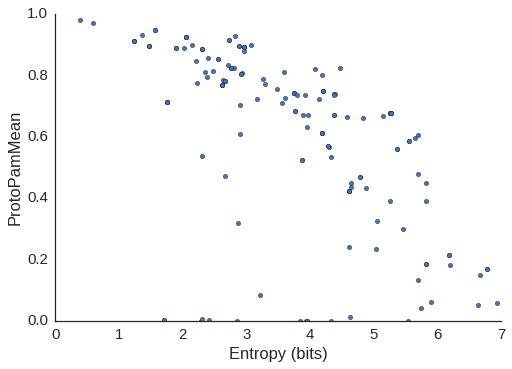

In [17]:
fig, ax = plt.subplots(1,1)
sum_df.plot(kind='scatter', x = 'Entropy', y = 'ProtoPamMean', ax=ax)
ax.set_xlim(0, 7)
ax.set_ylim(0, 1)
ax.set_xlabel('Entropy (bits)')
sbn.despine(ax=ax)
fig.savefig('../results/entropy_vs_protomean.png')

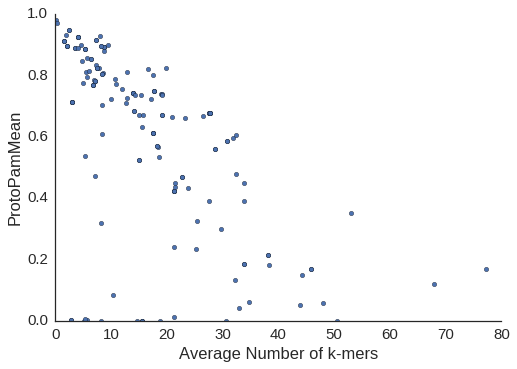

In [18]:
fig, ax = plt.subplots(1,1)
sum_df['AverageThings'] = sum_df['Entropy'].map(lambda x: x**2)
sum_df.plot(kind='scatter', y = 'ProtoPamMean', x = 'AverageThings', ax=ax)
ax.set_xlim(0, 80)
ax.set_ylim(0, 1)
ax.set_xlabel('Average Number of k-mers')
sbn.despine(ax=ax)
fig.savefig('../results/num_things_vs_protomean.png')

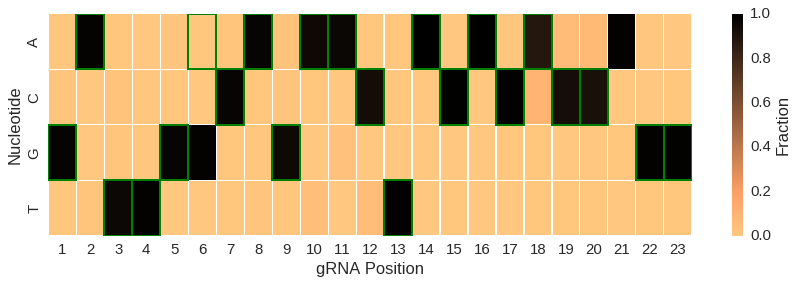

In [19]:
from collections import defaultdict

counts = defaultdict(float)
tot = 0
for n in score_df.query('Name == "LTR-2" & HasN == False')['Hit'].str.upper().values:
    tot += 1
    for p, l in enumerate(n):
        counts[(p, l)] += 1

        
order = 'ACGT'
d = []
for num in range(23):
    d.append([counts[(num, l)] for l in order])
        
        
res = pd.DataFrame(d, columns = list(order), index=range(1, 24)).T/tot


fig, ax = plt.subplots(1,1, figsize=(12, 4))

sbn.heatmap(res, ax=ax, cmap = 'copper_r', cbar_kws={'label': 'Fraction'}, linewidth=0.1)

gRNA = score_df.query('Name == "LTR-2" & HasN == False').iloc[0]['gRNA'].replace('.', '')


for n, l in enumerate(gRNA):
    
    bottom = (a for a, b in enumerate(order[::-1]+'.N') if b == l).next()
    
    ax.bar(left = n,
           width = 1,
           height = 1,
           bottom = bottom,
           linewidth = 2,
           edgecolor = 'g', 
           facecolor='None')
fig.tight_layout()
ax.set_xlabel('gRNA Position')
ax.set_ylabel('Nucleotide')
fig.savefig('../papers/Sullivan-2017-NatBiotech/example_gRNA.png', dpi=300)

In [20]:
res.to_excel('../data/LTR-2.freqs.xlsx')

In [21]:
score_df.query('Name == "LTR-2" & HasN == False').head()

,Citation,Direc,HasPam,Hit,Name,Region,Score,SeqID,Type,gRNA,gRNAType,gStart,gStop,ProtoPam,HasN
9390,26607397,Forward,True,GATTGGCACAACTACACACCAGG,LTR-2,LTR,0.369655,A0002-R06-PBMC-Genomic-LTR,Activation,GATTGACAGAACTACACACC.NGG,Activation,78.0,97.0,0.369655,False
9392,26607397,Forward,True,GATTGGCAGAACTACACACCAGG,LTR-2,LTR,0.605000,A0008-R00-PBMC-Genomic-LTR,Activation,GATTGACAGAACTACACACC.NGG,Activation,78.0,97.0,0.605000,False
9393,26607397,Forward,True,GATTGGCAGAACTACACACCAGG,LTR-2,LTR,0.605000,A0009-R00-PBMC-Genomic-LTR,Activation,GATTGACAGAACTACACACC.NGG,Activation,78.0,97.0,0.605000,False
9395,26607397,Forward,True,GATTAGCAGAACTACACACCAGG,LTR-2,LTR,0.605000,A0014-R07-PBMC-Genomic-LTR,Activation,GATTGACAGAACTACACACC.NGG,Activation,78.0,97.0,0.605000,False
9396,26607397,Forward,True,GATTGGCAGAACTACACACCAGG,LTR-2,LTR,0.605000,A0016-R00-PBMC-Genomic-LTR,Activation,GATTGACAGAACTACACACC.NGG,Activation,78.0,97.0,0.605000,False


In [22]:
SearchTools.gRNA_score_hit??